In [ ]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import

In [ ]:
size = 10000
var, alt = 'auto_cost', 0
path = '/content/drive/My Drive'
data1 = pd.read_csv(f'{path}/CMAP/chicago_processed.csv', index_col=0).sample(size, random_state=3)

In [ ]:
data1['high_edu'] = data1['educ'].isin([5, 6]).astype(int)
data1['hhveh_1'] = (data1['hhveh'] == 1).astype(int)
data1['hhsize_1'] = (data1['hhsize'] == 1).astype(int)
data1['high_inc'] = (data1['hhinc'] > 7).astype(int)

data1 = data1[['age', 'male', 'high_edu', 'hhsize_1', 'hhsize', 'hhveh', 'hhveh_1', 'high_inc', 'auto_time', 'auto_cost', 'train_time',
               'train_cost', 'active_time', 'mode']]

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [ ]:
train_size = int(size*.7)
val_size = int(size*.1)
test_size = size - train_size - val_size

data_train, data_remain = data[:train_size], data[train_size:]
data_val, data_test = data_remain[:val_size], data_remain[val_size:]

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [ ]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [ ]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [ ]:
l_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [ ]:
# Training set
true_share(data_train)

mode
Auto      0.693
Train     0.100
Active    0.207
Name: proportion, dtype: float64

In [ ]:
# Validation set
true_share(data_val)

mode
Auto      0.697
Train     0.089
Active    0.214
Name: proportion, dtype: float64

In [ ]:
# Test set
true_share(data_test)

mode
Auto      0.678
Train     0.106
Active    0.216
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:8]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [ ]:
data1_train, data1_remain = data1[:train_size], data1[train_size:]
data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]

In [ ]:
data1_train_lg = convert(data1_train)
data1_train_lg

,obs_id,alt_id,mode,age,male,high_edu,hhsize_1,hhsize,hhveh,hhveh_1,high_inc,time,cost
0,1,0,1,39,0,0,0,3,2,0,1,7.800000,5.844000
1,1,1,0,39,0,0,0,3,2,0,1,55.183333,2.550000
2,1,2,0,39,0,0,0,3,2,0,1,34.941667,0.000000
3,2,0,1,29,0,1,0,2,2,0,0,4.200000,6.572333
4,2,1,0,29,0,1,0,2,2,0,0,12.450000,2.408333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,6999,1,0,38,0,1,0,6,2,0,1,74.033333,3.250000
20996,6999,2,0,38,0,1,0,6,2,0,1,157.900000,0.000000
20997,7000,0,1,48,1,1,0,2,2,0,1,10.716667,5.006333
20998,7000,1,0,48,1,1,0,2,2,0,1,27.600000,2.608333


## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['male'] = [1, 2]
name['male'] = ['male_train', 'male_active']
spec['high_edu'] = [1, 2]
name['high_edu'] = ['high_edu_train', 'high_edu_active']
spec['hhsize'] = [1, 2]
name['hhsize'] = ['hhsize_train', 'hhsize_active']
spec['hhsize_1'] = [1, 2]
name['hhsize_1'] = ['hhsize_1_train', 'hhsize_1_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_train', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_train', 'hhveh_1_active']
spec['high_inc'] = [1, 2]
name['high_inc'] = ['high_inc_train', 'high_inc_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(23))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -4,710.2074


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,977
Method:                                MLE   Df Model:                           23
Date:                     Wed, 19 Jun 2024   Pseudo R-squ.:                   0.388
Time:                             04:13:43   Pseudo R-bar-squ.:               0.385
AIC:                             9,466.415   Log-Likelihood:             -4,710.207
BIC:                             9,624.049   LL-Null:                    -7,690.286
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
asc_train           0.1240      0.392      0.317      0.752      -0.644       0.892
asc_active         -0.3050      0.191     -1.597      0.110      -0.679       0.069
age_train          -0.0168      0.004     -4.646      0.000      -0.024      -0.010
age_active         -0.0157      0.003     -5.716      0.000      -0.021      -0.010
male_train          0.5913      0.088      6.711      0.000       0.419       0.764
male_active         0.5713      0.068      8.459      0.000       0.439       0.704
high_edu_train      0.4762      0.115      4.126      0.000       0.250       0.702
high_edu_active     0.5420      0.086      6.299      0.000       0.373       0.711
hhsize_train       -0.1501      0.052     -2.896      0.004      -0.252      -0.049
hhsize_active      -0.1785      0.041     -4.352      0.000      -0.259      -0.098
hhsize_1_train     -0.2433      0.136     -1.784      0.074      -0.511       0.024
hhsize_1_active    -0.2203      0.104     -2.121      0.034      -0.424      -0.017
hhveh_train        -0.6850      0.062    -11.089      0.000      -0.806      -0.564
hhveh_active       -0.8409      0.049    -17.084      0.000      -0.937      -0.744
hhveh_1_train      -0.5685      0.092     -6.175      0.000      -0.749      -0.388
hhveh_1_active     -0.3302      0.069     -4.796      0.000      -0.465      -0.195
high_inc_train      0.5887      0.113      5.222      0.000       0.368       0.810
high_inc_active     0.3336      0.083      4.020      0.000       0.171       0.496
time_auto          -0.0637      0.007     -8.564      0.000      -0.078      -0.049
time_train         -0.0364      0.003    -13.543      0.000      -0.042      -0.031
time_active        -0.0338      0.002    -21.773      0.000      -0.037      -0.031
cost_auto          -0.1793      0.017    -10.349      0.000      -0.213      -0.145
cost_train         -0.6884      0.157     -4.380      0.000      -0.996      -0.380
===================================================================================
"""

## Results

In [ ]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [ ]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [ ]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<7.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<7.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<7.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [ ]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -4710.2 | acc = 73.1% | F1 = 68.1%
Validation set: LL = -693.8  | acc = 73.7% | F1 = 69.0%
Test set:       LL = -1426.3 | acc = 71.9% | F1 = 66.9%


In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [ ]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.show()

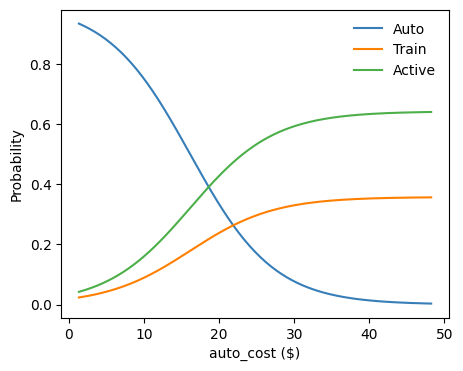

In [ ]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [ ]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [ ]:
eps = (lower1 - upper1) / 1e6

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [ ]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 0.998
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.998
Weak regularity   = 1.000


In [ ]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [ ]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 12]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 12]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 10:12]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 12]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [ ]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [ ]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [ ]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [ ]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [ ]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.savefig(f'{path}/R2_TasteNet/{NN.__name__}_10K.png', bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)

In [ ]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [ ]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4683.3 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -685.0  | acc = 72.4% | F1 = 66.7%
Test set:       LL = -1439.3 | acc = 70.8% | F1 = 64.6%
Model 2 
Training set:   LL = -4679.2 | acc = 73.6% | F1 = 68.0%
Validation set: LL = -682.5  | acc = 73.1% | F1 = 67.3%
Test set:       LL = -1441.0 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4662.7 | acc = 73.2% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1433.2 | acc = 71.4% | F1 = 65.4%
Model 4 
Training set:   LL = -4683.9 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -688.0  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.0 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4703.7 | acc = 73.1% | F1 = 67.2%
Validation set: LL = -679.7  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.2 | acc = 71.7% | F1 = 65.8%
Model 6 
Training set:   LL = -4689.6 | acc = 73.2% | F1 = 67.4%
Validat

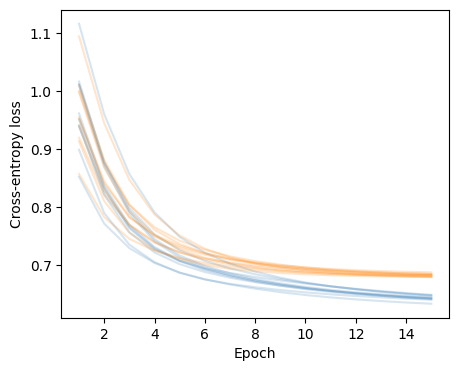

------------------------------ 
Training set:
Average log-likelihood = -4677.8 (19.9)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.0 (2.4)
Average accuracy       = 72.6% (0.4%)
Average F1 score       = 66.8% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1438.3 (5.8)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.4% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


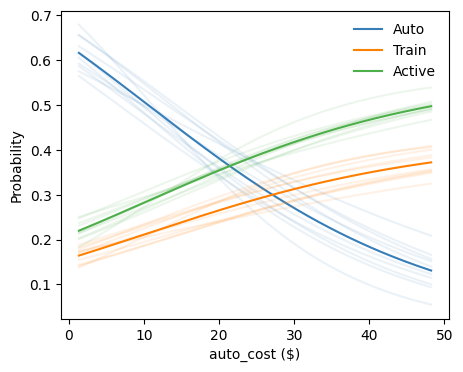

In [ ]:
result(TasteNet, 15, 'none')

### With ReLU constraint

In [ ]:
class TasteNet_ReLU(nn.Module):
    'Class of TasteNet with ReLU constraint'
    def __init__(self):
        super(TasteNet_ReLU, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        betas[:, 1:3] = -F.relu(-betas[:, 1:3])
        betas[:, 4:] = -F.relu(-betas[:, 4:])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4830.9 | acc = 72.9% | F1 = 67.0%
Validation set: LL = -700.5  | acc = 72.5% | F1 = 66.5%
Test set:       LL = -1500.6 | acc = 71.3% | F1 = 65.2%
Model 2 
Training set:   LL = -4704.5 | acc = 72.9% | F1 = 67.2%
Validation set: LL = -687.4  | acc = 72.9% | F1 = 67.1%
Test set:       LL = -1456.7 | acc = 70.9% | F1 = 64.9%
Model 3 
Training set:   LL = -4672.4 | acc = 73.3% | F1 = 67.7%
Validation set: LL = -680.5  | acc = 72.4% | F1 = 66.5%
Test set:       LL = -1441.3 | acc = 71.2% | F1 = 65.1%
Model 4 
Training set:   LL = -4810.3 | acc = 72.9% | F1 = 66.6%
Validation set: LL = -697.2  | acc = 72.3% | F1 = 65.9%
Test set:       LL = -1486.7 | acc = 71.2% | F1 = 64.6%
Model 5 
Training set:   LL = -4720.4 | acc = 72.9% | F1 = 67.0%
Validation set: LL = -679.8  | acc = 72.4% | F1 = 66.1%
Test set:       LL = -1443.8 | acc = 71.4% | F1 = 65.1%
Model 6 
Training set:   LL = -4708.2 | acc = 72.7% | F1 = 66.7%
Validat

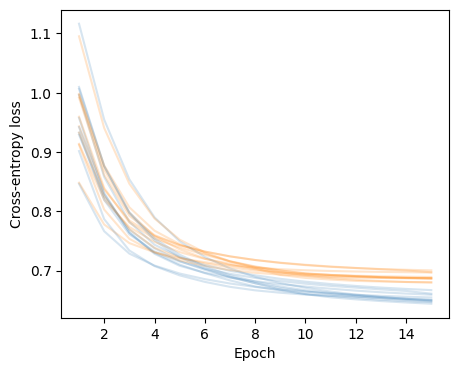

------------------------------ 
Training set:
Average log-likelihood = -4737.2 (51.2)
Average accuracy       = 72.9% (0.2%)
Average F1 score       = 67.1% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -689.2 (6.6)
Average accuracy       = 72.4% (0.3%)
Average F1 score       = 66.4% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1463.0 (20.1)
Average accuracy       = 71.2% (0.2%)
Average F1 score       = 65.0% (0.2%)
------------------------------ 
Training set:
Strong regularity = 0.423 (0.315)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.427 (0.319)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.426 (0.320)
Weak regularity   = 1.000 (0.000)
------------------------------


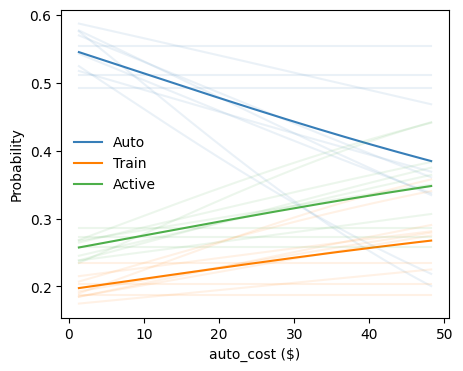

In [ ]:
result(TasteNet_ReLU, 15, 'none')

### With exponential constraint

In [ ]:
class TasteNet_Exp(nn.Module):
    'Class of TasteNet with exponential constraint'
    def __init__(self):
        super(TasteNet_Exp, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        betas[:, 1:3] = -torch.exp(-betas[:, 1:3])
        betas[:, 4:] = -torch.exp(-betas[:, 4:])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4697.4 | acc = 73.1% | F1 = 67.7%
Validation set: LL = -689.2  | acc = 71.9% | F1 = 67.0%
Test set:       LL = -1444.2 | acc = 71.4% | F1 = 66.1%
Model 2 
Training set:   LL = -4675.0 | acc = 73.4% | F1 = 68.0%
Validation set: LL = -683.4  | acc = 72.9% | F1 = 67.9%
Test set:       LL = -1445.3 | acc = 71.6% | F1 = 66.2%
Model 3 
Training set:   LL = -4666.1 | acc = 73.4% | F1 = 68.4%
Validation set: LL = -683.8  | acc = 73.0% | F1 = 68.4%
Test set:       LL = -1439.2 | acc = 71.7% | F1 = 66.5%
Model 4 
Training set:   LL = -4680.2 | acc = 73.5% | F1 = 68.5%
Validation set: LL = -690.4  | acc = 72.7% | F1 = 67.9%
Test set:       LL = -1441.5 | acc = 71.2% | F1 = 65.9%
Model 5 
Training set:   LL = -4694.8 | acc = 73.0% | F1 = 67.7%
Validation set: LL = -682.8  | acc = 72.6% | F1 = 67.3%
Test set:       LL = -1436.7 | acc = 72.2% | F1 = 67.0%
Model 6 
Training set:   LL = -4689.5 | acc = 73.4% | F1 = 68.2%
Validat

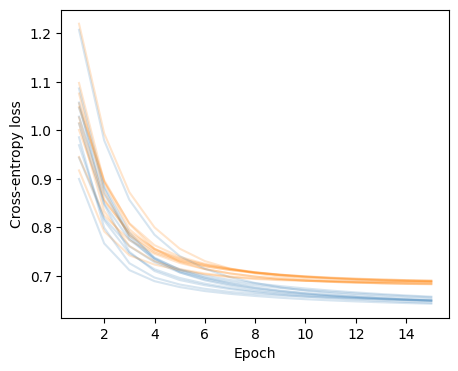

------------------------------ 
Training set:
Average log-likelihood = -4675.7 (19.0)
Average accuracy       = 73.3% (0.2%)
Average F1 score       = 68.1% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -687.1 (2.7)
Average accuracy       = 72.8% (0.4%)
Average F1 score       = 67.9% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1439.7 (6.1)
Average accuracy       = 71.7% (0.3%)
Average F1 score       = 66.4% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


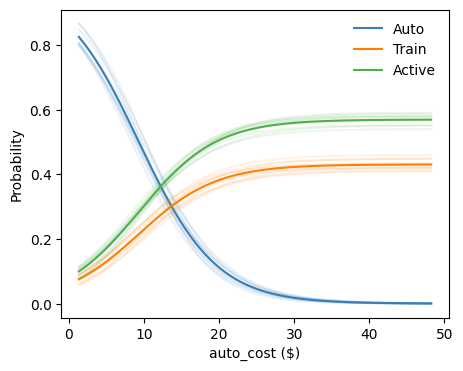

In [ ]:
result(TasteNet_Exp, 15, 'none')

# Final results

In [ ]:
train = results_train[['TasteNet_ReLU', 'TasteNet_Exp']]
train.iloc[[0]] = train.iloc[[0]].applymap(lambda x: f'${x:.1f}$')
train.iloc[1:] = train.iloc[1:].applymap(lambda x: f'{x:.3f}')
train.columns = ['ReLU', 'Exp']

train_std = results_train_std[['TasteNet_ReLU', 'TasteNet_Exp']]
train_std.iloc[[0]] = train_std.iloc[[0]].applymap(lambda x: f'({x:.2f})')
train_std.iloc[1:] = train_std.iloc[1:].applymap(lambda x: f'({x:.3f})')
train_std.columns = ['ReLU', 'Exp']

train = train.loc[train.index.repeat(2)]
train.iloc[1::2] = train_std
print(train.to_latex())

\begin{tabular}{lll}
\toprule
 & ReLU & Exp \\
\midrule
Log-likelihood & $-4737.2$ & $-4675.7$ \\
Log-likelihood & (51.18) & (18.97) \\
Accuracy & 0.729 & 0.733 \\
Accuracy & (0.002) & (0.002) \\
F1 score & 0.671 & 0.681 \\
F1 score & (0.004) & (0.003) \\
Strong regularity & 0.423 & 0.999 \\
Strong regularity & (0.315) & (0.000) \\
Weak regularity & 1.000 & 1.000 \\
Weak regularity & (0.000) & (0.000) \\
\bottomrule
\end{tabular}



In [ ]:
val = results_val[['TasteNet_ReLU', 'TasteNet_Exp']]
val.iloc[[0]] = val.iloc[[0]].applymap(lambda x: f'${x:.1f}$')
val.iloc[1:] = val.iloc[1:].applymap(lambda x: f'{x:.3f}')
val.columns = ['ReLU', 'Exp']

val_std = results_val_std[['TasteNet_ReLU', 'TasteNet_Exp']]
val_std = val_std.applymap(lambda x: f'({x:.3f})')
val_std.columns = ['ReLU', 'Exp']

val = val.loc[val.index.repeat(2)]
val.iloc[1::2] = val_std
print(val.to_latex())

\begin{tabular}{lll}
\toprule
 & ReLU & Exp \\
\midrule
Log-likelihood & $-689.2$ & $-687.1$ \\
Log-likelihood & (6.598) & (2.722) \\
Accuracy & 0.724 & 0.728 \\
Accuracy & (0.003) & (0.004) \\
F1 score & 0.664 & 0.679 \\
F1 score & (0.003) & (0.004) \\
Strong regularity & 0.427 & 1.000 \\
Strong regularity & (0.319) & (0.001) \\
Weak regularity & 1.000 & 1.000 \\
Weak regularity & (0.000) & (0.000) \\
\bottomrule
\end{tabular}



In [ ]:
test = results_test[['TasteNet_ReLU', 'TasteNet_Exp']]
test.iloc[[0]] = test.iloc[[0]].applymap(lambda x: f'${x:.1f}$')
test.iloc[1:] = test.iloc[1:].applymap(lambda x: f'{x:.3f}')
test.columns = ['ReLU', 'Exp']

test_std = results_test_std[['TasteNet_ReLU', 'TasteNet_Exp']]
test_std = test_std.applymap(lambda x: f'({x:.3f})')
test_std.columns = ['ReLU', 'Exp']

test = test.loc[test.index.repeat(2)]
test.iloc[1::2] = test_std
print(test.to_latex())

\begin{tabular}{lll}
\toprule
 & ReLU & Exp \\
\midrule
Log-likelihood & $-1463.0$ & $-1439.7$ \\
Log-likelihood & (20.051) & (6.073) \\
Accuracy & 0.712 & 0.717 \\
Accuracy & (0.002) & (0.003) \\
F1 score & 0.650 & 0.664 \\
F1 score & (0.002) & (0.004) \\
Strong regularity & 0.426 & 0.999 \\
Strong regularity & (0.320) & (0.001) \\
Weak regularity & 1.000 & 1.000 \\
Weak regularity & (0.000) & (0.000) \\
\bottomrule
\end{tabular}

